In [7]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import urllib

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
net = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Daewoon/.cache\torch\hub\v0.10.0.zip
d:\workspace\dwm\jupyter_basic\venv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
d:\workspace\dwm\jupyter_basic\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Daewoon/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████

In [9]:
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
img = Image.open(filename)

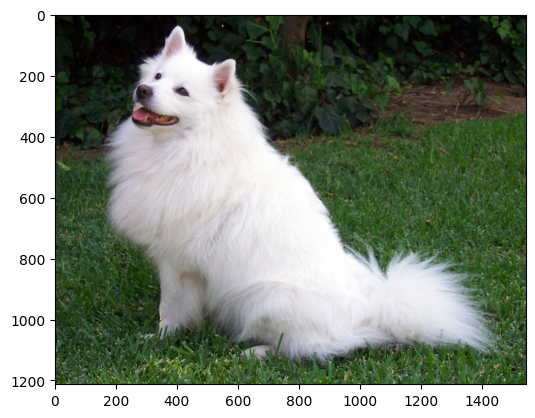

In [10]:
plt.imshow(img)

In [11]:
normalize = transforms.Normalize(
        mean=[0.48235, 0.45882, 0.407846],
        std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]
    )
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [12]:
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
ten = preprocess(img).unsqueeze(0)

net.eval()
with torch.no_grad():
    pred = net(ten)

In [14]:
pred.argmax() # Samoyed, Samoyede

tensor(258)

In [15]:
import torch.nn.functional as F
class GradCAM(nn.Module):
    def __init__(self, net, cls) -> None:
        super().__init__()
        self.net = net
        self.net.zero_grad()
        self.cls = cls
        self.act = {}
        self.grad = {}
    def backward_hook(self, net, inp, out):
        self.grad['grad'] = out
        return 
    def forward_hook(self, net, inp, out):
        self.act['act'] = out
        return 
    def get_gradcam(self, img, layer, org_shape):
        layer.register_forward_hook(self.forward_hook)
        layer.register_backward_hook(self.backward_hook)
        self.net.train() # net.eval() <- grad 비활성
        pred = self.net(img)
        score = pred[:, self.cls].squeeze()
        score.backward()
        grad = self.grad['grad']
        acti = self.act['act'] 
        # print(grad[0])
        b, c, u, v = grad[0].size()
        alpha = grad[0].view(b,c,-1).mean(2)
        alpha = alpha.view(b,c,1,1)
        cam = F.relu((alpha * acti).sum(1, keepdim=True)).detach().numpy().squeeze()
        cam = cv2.resize(cam, org_shape, cv2.INTER_LINEAR)
        return cam

In [17]:
# from GradCAM import GradCAM
gradcam = GradCAM(net, pred.argmax())

In [18]:
gc = gradcam.get_gradcam(ten, net.features[29], np.array(img).shape[:2])

d:\workspace\dwm\jupyter_basic\venv\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


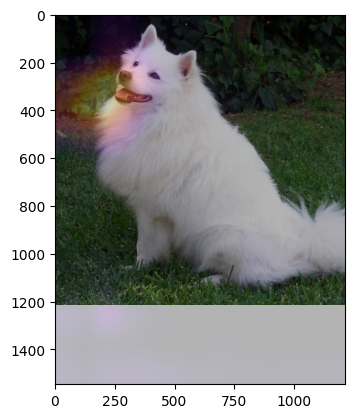

In [19]:
plt.imshow(img)
plt.imshow(gc, 'inferno', alpha=0.3)